# Usage of transaction data to predict credit event

**Team Member**
| Name | Student Number |
| :----: | :--------------: |
| Yuyang Zhang | 2301212424 |
| Ruiyang Ge | 2301212326 |

## Purpose of this Machine Learning Project
1. As is introduced in `README`, this project is about prdicting default event. However, due to the imbalance of the data, our main goal is to improve __recall__ , or minimize the false negative rate, because the potential default events would bring significant losses to the bank.
2. In order for the bank to quickly identity risks, we need to output the probability of defalut for each company.

## 0. Abstract

Here we will focus on introducing the research strategies we use.

- The first and most important point is that we are dealing with default related forecasts. Due to the serious imbalance of default data, we use the **oversampling** method to achieve better results. In addition, in this dataset, we focus more on Recall because we want to predict as many customers as possible who are likely to default, not just improve the accuracy of our own predictions.

- Due to the sparsity of transaction data, we spend a lot of effort on data cleaning and processing. As the project progressed, we found that it might be better to focus more on **feature engineering** rather than just optimizing Recall, because there seemed to be a lot to explore in the data. Default forecasting using transaction data is largely feature-oriented. We construct and screen many useful features from the perspectives of classification summation, time weighting, difference and volatility. In the end, we got a better result.

- To our delight, after optimizing the feature engineering part, **we improved the Recall to more than 90%**. We know in class that 90% is not good for extremely lopsided data that actually has around 99% positives, but considering that we need to make a prediction with less than 40 actual positives, it's actually relatively good.

## 1. Data processong & description

In this part, we need to process the data provided by HSBC, and merge them into one dataset:
- Delete all samples entirely filled with zeros.
- Fill the missing data with appropriate values. For some missing transaction count, we fill them with 1.
- Construct new features with different methods.

### 1.1 Read and merge data.

In [1]:
import tensorflow as tf
import numpy as np
import itertools
from tensorflow import keras
from tensorflow.keras import layers
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
import statsmodels.api as sm
import matplotlib.dates as dates
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras import optimizers
import time
from functools import reduce
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn import metrics
from sklearn.metrics import precision_recall_curve, average_precision_score, confusion_matrix, f1_score, roc_curve, auc
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
plt.style.use('ggplot')
# RandomUnderSampler
from imblearn.under_sampling import RandomUnderSampler #oversampling and undersampling
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE

In [2]:
# Read import_data, export_data and target.
import_data=pd.read_csv("/Users/geo/Desktop/MLF-Project/data/import_data.csv").drop(['Unnamed: 0'],axis=1)
export_data=pd.read_csv("/Users/geo/Desktop/MLF-Project/data/export_data.csv").drop(['Unnamed: 0'],axis=1)
target=pd.read_csv("/Users/geo/Desktop/MLF-Project/data/Target.csv").drop(['Unnamed: 0'],axis=1)
# Set columns with transaction amount data but no transaction count data to 1. 
import_data.rename(columns={'imp_Product5_6_cnt_t':'imp_Product5_6_Trans_cnt_t'},inplace=True)
for i in {1,2,7}:
    import_data.loc[(import_data[f'imp_Product{i}_Trans_amt_t'] != 0) & (import_data[f'imp_Product{i}_Trans_cnt_t'] == 0),f'imp_Product{i}_Trans_cnt_t'] = 1
import_data.loc[(((import_data['imp_Product3_Trans_amt_t'] != 0) | (import_data['imp_Product4_Trans_amt_t'] != 0)) &(import_data['imp_Product3_4_Trans_cnt_t'] == 0)),'imp_Product3_4_Trans_cnt_t'] = 1
import_data.loc[(((import_data['imp_Product5_Trans_amt_t'] != 0) | (import_data['imp_Product6_Trans_amt_t'] != 0)) &(import_data['imp_Product5_6_Trans_cnt_t'] == 0)),'imp_Product5_6_Trans_cnt_t'] = 1

for i in {1,2,3,4,5}:
    export_data.loc[(export_data[f'ex_Product{i}_Trans_amt_t'] != 0) & (export_data[f'ex_Product{i}_Trans_cnt_t'] == 0),f'ex_Product{i}_Trans_cnt_t'] = 1

In [3]:
# Merge data and drop 0 rows.
data=pd.merge(import_data,export_data,how='outer',on=['COHORT_MONTH','COMPANY_ID','IMAGE_DT'])
data=pd.merge(data,target,how='left',on=['COHORT_MONTH','COMPANY_ID']).dropna()
data['COHORT_MONTH'] = pd.to_datetime(data['COHORT_MONTH'])
data['IMAGE_DT'] = pd.to_datetime(data['IMAGE_DT'])
data.iloc[:, 4:] = data.iloc[:, 4:].clip(lower=0)
data=data.sort_values(['COMPANY_ID','IMAGE_DT'])
data.head()

,COHORT_MONTH,COMPANY_ID,IMAGE_DT,imp_Product1_Trans_amt_t,imp_Product2_Trans_amt_t,imp_Product3_Trans_amt_t,imp_Product4_Trans_amt_t,imp_Product5_Trans_amt_t,imp_Product6_Trans_amt_t,imp_Product7_Trans_amt_t,...,ex_Product2_Trans_amt_t,ex_Product3_Trans_amt_t,ex_Product4_Trans_amt_t,ex_Product5_Trans_amt_t,ex_Product1_Trans_cnt_t,ex_Product2_Trans_cnt_t,ex_Product3_Trans_cnt_t,ex_Product4_Trans_cnt_t,ex_Product5_Trans_cnt_t,credit_event
24,2020-06-30,4,2019-07-31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,198.639649,0.0,0.0,0.0,0.0,1.0,0.0,0.0
25,2020-06-30,4,2019-08-31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
26,2020-06-30,4,2019-09-30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
27,2020-06-30,4,2019-10-31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
28,2020-06-30,4,2019-11-30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### 1.2 Feature engineering.

#### 1.2.1 EWM (Time Weighting)

*This turned out to be the most powerful way from God's perspective.*

For specific `COHORT_MONTH` & `COMPANY_ID`, we need to synthesize new features.

- Timing weighting: $\hat{\mu}_t = \sum_{\tau=0}^{k} (1 - \alpha)^\tau Y_{t - \tau}$

- Constuct total export and import data to caputure the unique information of export and import data.

In [4]:
## Timing weighting method
data['IMAGE_DT_month'] = data['IMAGE_DT'].dt.month
def custom_return(a):
    if 6 <= a <= 12:
        return 18 - a
    else:
        return 6 - a
data['result'] = data['IMAGE_DT_month'].apply(custom_return)
def ewm_zyy(group):
    a = 0.1
    image_dt_months = group['result']
    weights = np.power(1 - a, image_dt_months - 1)

    numeric_columns = group.select_dtypes(include=[np.number]).columns
    weighted_data = group[numeric_columns].mul(weights, axis=0)
    
  
    weighted_sum = weighted_data.sum(axis=0)
    return weighted_sum

grouped_data = data.groupby(['COMPANY_ID', 'COHORT_MONTH'])
weighted_sums = grouped_data.apply(ewm_zyy)
weighted_sums.drop(columns = 'COMPANY_ID', inplace = True)
weighted_sums.drop(columns = 'IMAGE_DT_month', inplace = True)
weighted_sums.drop(columns = 'result', inplace = True)
weighted_sums['credit_event'] = weighted_sums['credit_event'].ne(0).astype(int)
data = weighted_sums.reset_index()
data.head()

/var/folders/1s/gq5q_hsx1yqb2rtz9cll80f00000gn/T/ipykernel_13746/519628825.py:22: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  weighted_sums = grouped_data.apply(ewm_zyy)


,COMPANY_ID,COHORT_MONTH,imp_Product1_Trans_amt_t,imp_Product2_Trans_amt_t,imp_Product3_Trans_amt_t,imp_Product4_Trans_amt_t,imp_Product5_Trans_amt_t,imp_Product6_Trans_amt_t,imp_Product7_Trans_amt_t,imp_Product1_Trans_cnt_t,...,ex_Product2_Trans_amt_t,ex_Product3_Trans_amt_t,ex_Product4_Trans_amt_t,ex_Product5_Trans_amt_t,ex_Product1_Trans_cnt_t,ex_Product2_Trans_cnt_t,ex_Product3_Trans_cnt_t,ex_Product4_Trans_cnt_t,ex_Product5_Trans_cnt_t,credit_event
0,4,2020-06-30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,69.261363,0.0,0.0,0.0,0.0,0.348678,0.0,0
1,4,2021-06-30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0
2,12,2020-06-30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0
3,12,2021-06-30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0
4,12,2022-06-30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0


#### 1.2.2 Sum by category

- For specific `COHORT_MONTH` & `COMPANY_ID`, we believe that it is possible to directly sum up all import and export data.

In [5]:
# Unqiue export and import features.
columns_to_sum_imp = [f'imp_Product{i}_Trans_amt_t' for i in range(1,8)]
columns_to_count_imp = [f'imp_Product{i}_Trans_cnt_t' for i in ['1','2','3_4','5_6','7']]
columns_to_sum_exp = [f'ex_Product{i}_Trans_amt_t' for i in range(1,6)]
columns_to_count_exp = [f'ex_Product{i}_Trans_cnt_t' for i in range(1,6)]

import_amount_df = import_data.groupby(['COMPANY_ID','COHORT_MONTH'])[columns_to_sum_imp].sum().sum(axis=1).reset_index().rename(columns = {0:'imp_Trans_amt'})
import_count_df = import_data.groupby(['COMPANY_ID','COHORT_MONTH'])[columns_to_count_imp].sum().sum(axis=1).reset_index().rename(columns = {0:'imp_Trans_count'})
import_total_feature = pd.merge(import_amount_df,import_count_df,how='outer',on=['COHORT_MONTH','COMPANY_ID']).dropna()
# import_data = pd.merge(import_data,import_total_feature,how='left',on=['COHORT_MONTH','COMPANY_ID']).dropna()

export_amount_df = export_data.groupby(['COMPANY_ID','COHORT_MONTH'])[columns_to_sum_exp].sum().sum(axis=1).reset_index().rename(columns = {0:'exp_Trans_amt'})
export_count_df = export_data.groupby(['COMPANY_ID','COHORT_MONTH'])[columns_to_count_exp].sum().sum(axis=1).reset_index().rename(columns = {0:'exp_Trans_count'})
export_total_feature = pd.merge(export_amount_df,export_count_df,how='outer',on=['COHORT_MONTH','COMPANY_ID']).dropna()
# export_data = pd.merge(export_data,export_total_feature,how='left',on=['COHORT_MONTH','COMPANY_ID']).dropna()

data_total_feature = pd.merge(import_total_feature,export_total_feature,how='outer',on=['COHORT_MONTH','COMPANY_ID']).dropna()
data_total_feature['COHORT_MONTH'] = pd.to_datetime(data_total_feature['COHORT_MONTH'])
data = pd.merge(data,data_total_feature,how='left',on=['COMPANY_ID','COHORT_MONTH']).dropna()

# Move 'credit_event' column to the end.
columns = list(data.columns)
columns.remove('credit_event')
columns.append('credit_event')
data_new = data[columns]
data_new.head()
data = data_new.copy()
data.head()

,COMPANY_ID,COHORT_MONTH,imp_Product1_Trans_amt_t,imp_Product2_Trans_amt_t,imp_Product3_Trans_amt_t,imp_Product4_Trans_amt_t,imp_Product5_Trans_amt_t,imp_Product6_Trans_amt_t,imp_Product7_Trans_amt_t,imp_Product1_Trans_cnt_t,...,ex_Product1_Trans_cnt_t,ex_Product2_Trans_cnt_t,ex_Product3_Trans_cnt_t,ex_Product4_Trans_cnt_t,ex_Product5_Trans_cnt_t,imp_Trans_amt,imp_Trans_count,exp_Trans_amt,exp_Trans_count,credit_event
0,4,2020-06-30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.348678,0.0,0.0,0.0,198.639649,1.0,0
1,4,2021-06-30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0
2,12,2020-06-30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0
3,12,2021-06-30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0
4,12,2022-06-30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0


#### 1.2.3 Difference

- Based on 1.2.2, we can take *difference method* into consideration.

- We hoped to construct some useful factors from the changes in transaction amount and transaction count, as well as volatility, but found that they did not play a role in optimizing Recall. We still put the code here.

**Method 1**. Consider volotility of the difference by each product.

In [6]:
# columns_to_sum_imp = [f'imp_Product{i}_Trans_amt_t' for i in range(1,8)]
# columns_to_count_imp = [f'imp_Product{i}_Trans_cnt_t' for i in ['1','2','3_4','5_6','7']]
# columns_to_sum_exp = [f'ex_Product{i}_Trans_amt_t' for i in range(1,6)]
# columns_to_count_exp = [f'ex_Product{i}_Trans_cnt_t' for i in range(1,6)]

# import_amount_df = import_data.groupby(['COMPANY_ID','COHORT_MONTH'])[columns_to_sum_imp].sum().sum(axis=1).reset_index().rename(columns = {0:'imp_Trans_amt'})
# Std_import_amount_df = import_data.groupby(['COMPANY_ID','COHORT_MONTH'])[columns_to_sum_imp].std().sum(axis=1).reset_index().rename(columns = {0:'Std_imp_Trans_amt'})
# import_count_df = import_data.groupby(['COMPANY_ID','COHORT_MONTH'])[columns_to_count_imp].sum().sum(axis=1).reset_index().rename(columns = {0:'imp_Trans_count'})
# Std_import_count_df = import_data.groupby(['COMPANY_ID','COHORT_MONTH'])[columns_to_count_imp].std().sum(axis=1).reset_index().rename(columns = {0:'Std_imp_Trans_count'})
# import_total_feature = pd.merge(import_amount_df,import_count_df,how='left',on=['COHORT_MONTH','COMPANY_ID']).dropna()
# import_total_feature = pd.merge(import_total_feature,Std_import_amount_df,how='left',on=['COHORT_MONTH','COMPANY_ID']).dropna()
# import_total_feature = pd.merge(import_total_feature,Std_import_count_df,how='left',on=['COHORT_MONTH','COMPANY_ID']).dropna()

# export_amount_df = export_data.groupby(['COMPANY_ID','COHORT_MONTH'])[columns_to_sum_exp].sum().sum(axis=1).reset_index().rename(columns = {0:'exp_Trans_amt'})
# Std_export_amount_df = export_data.groupby(['COMPANY_ID','COHORT_MONTH'])[columns_to_sum_exp].std().sum(axis=1).reset_index().rename(columns = {0:'Std_exp_Trans_amt'})
# export_count_df = export_data.groupby(['COMPANY_ID','COHORT_MONTH'])[columns_to_count_exp].sum().sum(axis=1).reset_index().rename(columns = {0:'exp_Trans_count'})
# Std_export_count_df = export_data.groupby(['COMPANY_ID','COHORT_MONTH'])[columns_to_count_exp].std().sum(axis=1).reset_index().rename(columns = {0:'Std_exp_Trans_count'})
# export_total_feature = pd.merge(export_amount_df,export_count_df,how='left',on=['COHORT_MONTH','COMPANY_ID']).dropna()
# export_total_feature = pd.merge(export_total_feature,Std_export_amount_df,how='left',on=['COHORT_MONTH','COMPANY_ID']).dropna()
# export_total_feature = pd.merge(export_total_feature,Std_export_count_df,how='left',on=['COHORT_MONTH','COMPANY_ID']).dropna()

# data_total_feature = pd.merge(import_total_feature,export_total_feature,how='outer',on=['COHORT_MONTH','COMPANY_ID']).dropna()
# data_total_feature['COHORT_MONTH'] = pd.to_datetime(data_total_feature['COHORT_MONTH'])
# data = pd.merge(data,data_total_feature,how='left',on=['COMPANY_ID','COHORT_MONTH']).dropna()
# data.head()

**Method 2**. Calculate the total volume of all transactions in a month firstly, and then consider the volatility of these volumes

In [7]:
# import_data['Diff_import_amount_df'] = import_data[columns_to_sum_imp].sum(axis=1)
# import_data['Diff_import_count_df'] = import_data[columns_to_count_imp].sum(axis=1)
# export_data['Diff_export_amount_df'] = export_data[columns_to_sum_exp].sum(axis=1)
# export_data['Diff_export_count_df'] = export_data[columns_to_count_exp].sum(axis=1)
# grouped1 = import_data.groupby(['COMPANY_ID','COHORT_MONTH'])
# grouped2 = export_data.groupby(['COMPANY_ID','COHORT_MONTH'])
# def calculate_std_diff1(group):
#     std_diff = group['Diff_import_amount_df'].diff().fillna(0).std()
#     return std_diff
# def calculate_std_diff2(group):
#     std_diff = group['Diff_import_count_df'].diff().fillna(0).std()
#     return std_diff
# def calculate_std_diff3(group):
#     std_diff = group['Diff_export_amount_df'].diff().fillna(0).std()
#     return std_diff
# def calculate_std_diff4(group):
#     std_diff = group['Diff_export_count_df'].diff().fillna(0).std()
#     return std_diff
# result_imp_amt = grouped1.apply(calculate_std_diff1).fillna(0).reset_index().rename(columns = {0:'Diff_imp_Trans_amt'})
# result_imp_cnt = grouped1.apply(calculate_std_diff2).fillna(0).reset_index().rename(columns = {0:'Diff_imp_Trans_cnt'})
# result_exp_amt = grouped2.apply(calculate_std_diff3).fillna(0).reset_index().rename(columns = {0:'Diff_exp_Trans_amt'})
# result_exp_cnt = grouped2.apply(calculate_std_diff4).fillna(0).reset_index().rename(columns = {0:'Diff_exp_Trans_cnt'})

# # add the 4 factors together into 'data'
# import_total_feature1 = pd.merge(result_imp_amt,result_imp_cnt,how='outer',on=['COHORT_MONTH','COMPANY_ID']).dropna()
# import_total_feature2 = pd.merge(import_total_feature,import_total_feature1,how='outer',on=['COHORT_MONTH','COMPANY_ID']).dropna()
# export_total_feature1 = pd.merge(result_exp_amt,result_exp_cnt,how='outer',on=['COHORT_MONTH','COMPANY_ID']).dropna()
# export_total_feature2 = pd.merge(export_total_feature,export_total_feature1,how='outer',on=['COHORT_MONTH','COMPANY_ID']).dropna()

# data_total_feature = pd.merge(import_total_feature2,export_total_feature2,how='outer',on=['COHORT_MONTH','COMPANY_ID']).dropna()
# data_total_feature['COHORT_MONTH'] = pd.to_datetime(data_total_feature['COHORT_MONTH'])
# data = pd.merge(data,data_total_feature,how='left',on=['COMPANY_ID','COHORT_MONTH']).dropna()
# data = data.drop(columns={'imp_Trans_amt_y','imp_Trans_count_y','exp_Trans_amt_y','exp_Trans_count_y'})
# data = data.rename(columns={'imp_Trans_amt_x':'imp_Trans_amt','imp_Trans_count_x':'imp_Trans_count','exp_Trans_amt_x':'exp_Trans_amt','exp_Trans_count_x':'exp_Trans_count'})
# data.head()

### 1.3 Data description

In [8]:
data.describe().T

,count,mean,min,25%,50%,75%,max,std
COMPANY_ID,12866.0,10990.010804,4.0,5411.0,12198.0,16714.0,18727.0,5936.872996
COHORT_MONTH,12866,2021-07-07 20:35:57.873465088,2020-06-30 00:00:00,2020-06-30 00:00:00,2021-06-30 00:00:00,2022-06-30 00:00:00,2022-06-30 00:00:00,NaN
imp_Product1_Trans_amt_t,12866.0,19.432832,0.0,0.0,0.0,0.0,12258.665479,320.03741
imp_Product2_Trans_amt_t,12866.0,356.376861,0.0,0.0,0.0,0.0,105473.343453,2932.190782
imp_Product3_Trans_amt_t,12866.0,20.161548,0.0,0.0,0.0,0.0,31950.897738,405.933727
imp_Product4_Trans_amt_t,12866.0,368.959242,0.0,0.0,0.0,0.0,104422.126623,2949.952603
imp_Product5_Trans_amt_t,12866.0,104.245473,0.0,0.0,0.0,0.0,30457.785204,771.053257
imp_Product6_Trans_amt_t,12866.0,416.147473,0.0,0.0,0.0,0.0,109599.389092,2473.46922
imp_Product7_Trans_amt_t,12866.0,192.685509,0.0,0.0,0.0,0.0,61193.07157,1358.269815
imp_Product1_Trans_cnt_t,12866.0,0.017332,0.0,0.0,0.0,0.0,12.138108,0.287675


## 2. Using machine learning models to train and predict the credit evet.

In this part, we do our main job of machine learning:
- Split the dataset into train and test set.
- Do the standardization.
- Release the data imbalance using __oversampling__ method.
- Select features by __random forest__.
- Using different Machine learning method (`LR`, `SVM`, `Decision Tree`, `Random Forest`, `LSTM`) to train and predict.

### 2.1 Data Preprocessing and Visualization

In [9]:
# Split the data.
train, test = train_test_split(data,test_size = 0.25,random_state = 42,stratify = data['credit_event'])

# Standardization.
stdlist = list(train.columns)
stdlist.remove('credit_event')
stdlist.remove('COHORT_MONTH')
stdlist.remove('COMPANY_ID')
train[stdlist]
stdsc = StandardScaler()
train[stdlist] = stdsc.fit_transform(train[stdlist])
test[stdlist] = stdsc.fit_transform(test[stdlist])


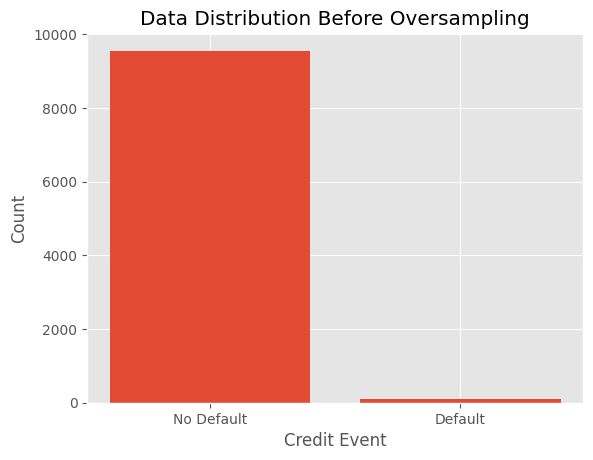

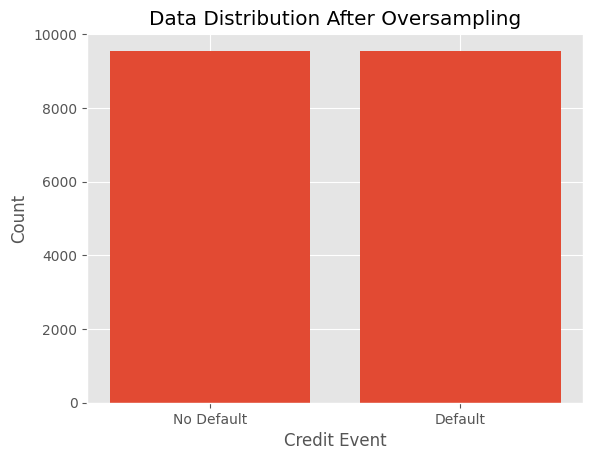

In [10]:
# data before and after oversampling.
before_oversampling = train.groupby(['credit_event'])['credit_event'].count()

#oversampling
dlist=list(train.columns)
dlist.remove('COHORT_MONTH')
dlist.remove('COMPANY_ID')
#dlist.remove('IMAGE_DT')
x=train[dlist]
y=train['credit_event']

smote = SMOTE()
X_res, y_new2 = smote.fit_resample(x, y)
after_oversampling = X_res.groupby(['credit_event']).size()

# Data before oversampling
plt.bar(before_oversampling.index, before_oversampling.values)
plt.title('Data Distribution Before Oversampling')
plt.xlabel('Credit Event')
plt.ylabel('Count')
plt.xticks(before_oversampling.index, labels=['No Default', 'Default'])  # Assuming 'No Event' is 0 and 'Event' is 1
plt.show()

# Data after oversampling
plt.bar(after_oversampling.index, after_oversampling.values)
plt.title('Data Distribution After Oversampling')
plt.xlabel('Credit Event')
plt.ylabel('Count')
plt.xticks(after_oversampling.index, labels=['No Default', 'Default'])  # Assuming 'No Event' is 0 and 'Event' is 1
plt.show()

In [11]:
X_res.describe().T

,count,mean,std,min,25%,50%,75%,max
imp_Product1_Trans_amt_t,19112.0,-0.029158,0.711168,-0.058889,-0.058889,-0.058889,-0.058889,39.280201
imp_Product2_Trans_amt_t,19112.0,-0.035486,0.744652,-0.120170,-0.120170,-0.120170,-0.120170,36.008139
imp_Product3_Trans_amt_t,19112.0,-0.003094,0.740196,-0.048085,-0.048085,-0.048085,-0.048085,69.767751
imp_Product4_Trans_amt_t,19112.0,-0.039601,0.746004,-0.127016,-0.127016,-0.127016,-0.127016,36.815185
imp_Product5_Trans_amt_t,19112.0,0.090983,1.249178,-0.139071,-0.139071,-0.139071,-0.139071,27.153386
imp_Product6_Trans_amt_t,19112.0,0.030453,0.893049,-0.163163,-0.163163,-0.163163,-0.163163,42.641519
imp_Product7_Trans_amt_t,19112.0,0.086769,1.191065,-0.138967,-0.138967,-0.138967,-0.138967,43.538907
imp_Product1_Trans_cnt_t,19112.0,-0.028943,0.711159,-0.058456,-0.058456,-0.058456,-0.058456,43.419817
imp_Product2_Trans_cnt_t,19112.0,-0.040927,0.789957,-0.166171,-0.166171,-0.166171,-0.166171,33.044170
imp_Product3_4_Trans_cnt_t,19112.0,-0.029286,0.796759,-0.132182,-0.132182,-0.132182,-0.132182,46.446311


In [12]:
X_res[stdlist].corr()

,imp_Product1_Trans_amt_t,imp_Product2_Trans_amt_t,imp_Product3_Trans_amt_t,imp_Product4_Trans_amt_t,imp_Product5_Trans_amt_t,imp_Product6_Trans_amt_t,imp_Product7_Trans_amt_t,imp_Product1_Trans_cnt_t,imp_Product2_Trans_cnt_t,imp_Product3_4_Trans_cnt_t,...,ex_Product5_Trans_amt_t,ex_Product1_Trans_cnt_t,ex_Product2_Trans_cnt_t,ex_Product3_Trans_cnt_t,ex_Product4_Trans_cnt_t,ex_Product5_Trans_cnt_t,imp_Trans_amt,imp_Trans_count,exp_Trans_amt,exp_Trans_count
imp_Product1_Trans_amt_t,1.000000,0.026321,0.222325,0.106046,0.001127,0.001925,0.065806,0.906091,0.067256,0.172984,...,0.033803,0.087282,-0.001068,0.027867,0.017442,0.023716,0.103521,0.117093,0.033354,0.039584
imp_Product2_Trans_amt_t,0.026321,1.000000,0.307158,0.980928,0.169784,0.163125,0.206872,0.029567,0.772459,0.695889,...,0.103925,0.060365,0.011186,0.110111,0.082003,0.034628,0.765247,0.443118,0.313552,0.100961
imp_Product3_Trans_amt_t,0.222325,0.307158,1.000000,0.259521,0.061029,0.038562,0.075463,0.213592,0.255109,0.230387,...,0.006184,0.077122,-0.001553,0.029490,0.006820,0.005869,0.290673,0.171538,0.036730,0.028151
imp_Product4_Trans_amt_t,0.106046,0.980928,0.259521,1.000000,0.174192,0.169924,0.220954,0.100170,0.759747,0.720936,...,0.116519,0.060140,0.005062,0.123933,0.090435,0.044494,0.774271,0.460968,0.326773,0.110657
imp_Product5_Trans_amt_t,0.001127,0.169784,0.061029,0.174192,1.000000,0.556976,0.716062,0.005849,0.248254,0.267143,...,0.024796,0.194080,-0.004529,0.072783,0.033287,0.032187,0.628260,0.636340,0.089321,0.090331
imp_Product6_Trans_amt_t,0.001925,0.163125,0.038562,0.169924,0.556976,1.000000,0.530837,0.005371,0.228928,0.231620,...,0.105003,0.193085,0.028854,0.250263,0.155176,0.095889,0.653880,0.638696,0.383060,0.219297
imp_Product7_Trans_amt_t,0.065806,0.206872,0.075463,0.220954,0.716062,0.530837,1.000000,0.070216,0.286120,0.332495,...,0.041920,0.200522,-0.004704,0.060723,-0.002016,0.048341,0.680210,0.696897,0.081814,0.069089
imp_Product1_Trans_cnt_t,0.906091,0.029567,0.213592,0.100170,0.005849,0.005371,0.070216,1.000000,0.081084,0.180431,...,0.026862,0.131787,-0.001060,0.030334,0.014708,0.021901,0.102636,0.129849,0.032139,0.047271
imp_Product2_Trans_cnt_t,0.067256,0.772459,0.255109,0.759747,0.248254,0.228928,0.286120,0.081084,1.000000,0.862034,...,0.076100,0.157510,0.035113,0.107684,0.114882,0.031180,0.688434,0.609495,0.239970,0.149602
imp_Product3_4_Trans_cnt_t,0.172984,0.695889,0.230387,0.720936,0.267143,0.231620,0.332495,0.180431,0.862034,1.000000,...,0.079168,0.089190,0.010865,0.086683,0.086295,0.035789,0.668609,0.642043,0.174846,0.108391


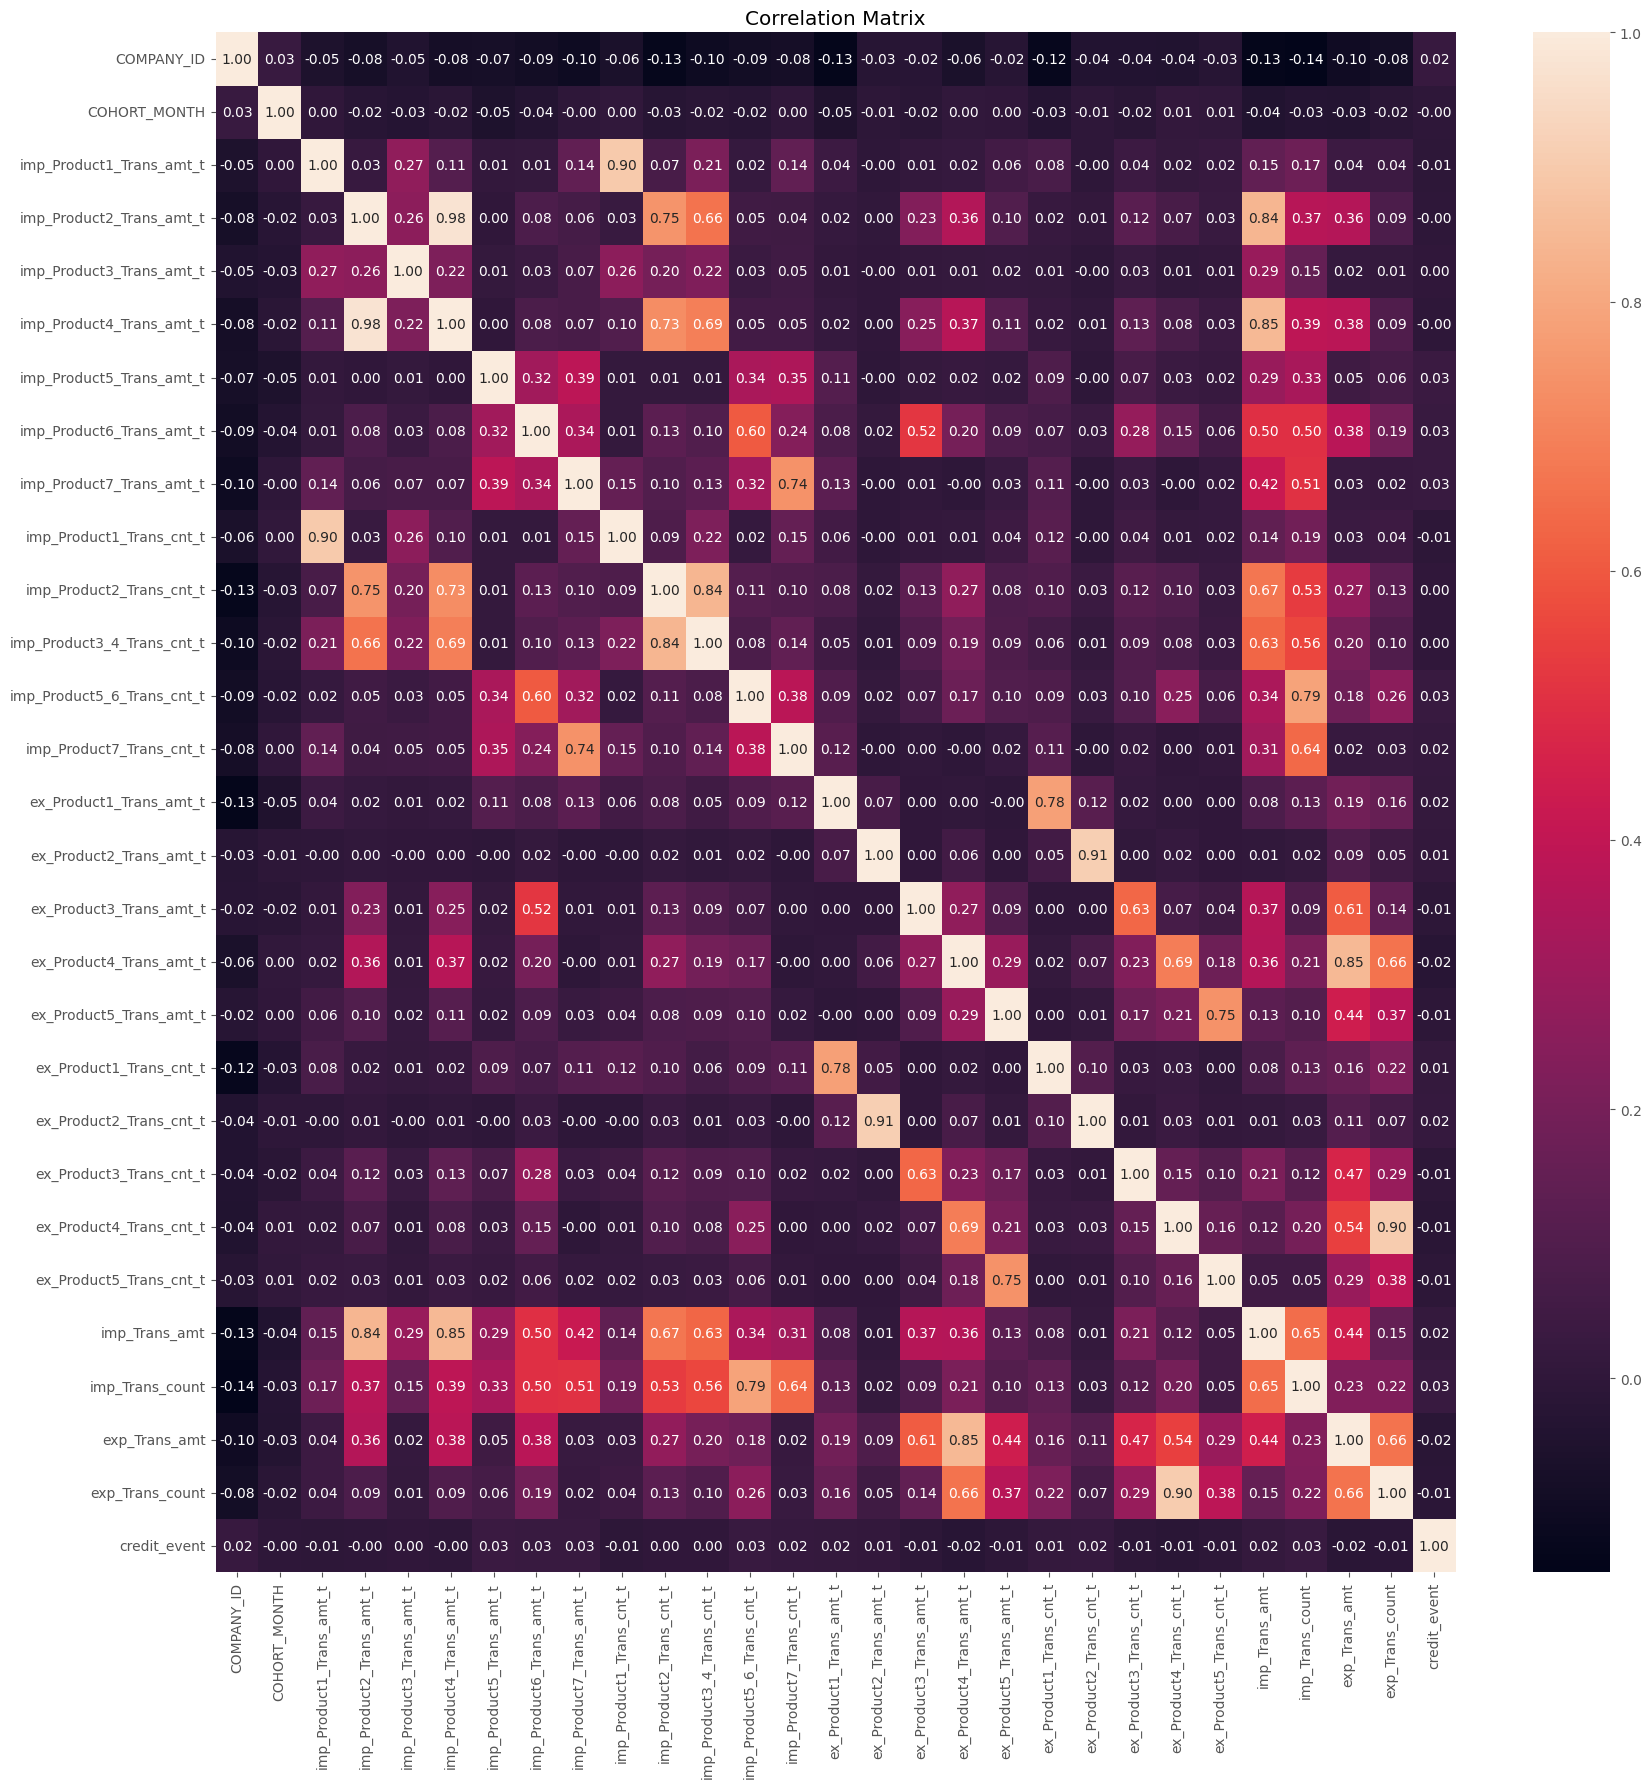

In [13]:
# correlation heatmap
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def plot_correlation_matrix(df, fill_value='mean', correlation_type='pearson', figsize=(20,20)):
    """
    Plot a heatmap of the correlation matrix for a DataFrame.

    Parameters:
    - df (pandas.DataFrame): DataFrame containing the data.
    - fill_value (str or float): Strategy to fill missing values. Options: 'mean', 'median', or a specific numerical value.
    - correlation_type (str): Type of correlation coefficient to compute. Options: 'pearson', 'spearman', 'kendall'.

    Returns:
    - None, but displays the heatmap.
    """
    if isinstance(fill_value, str):
        if fill_value == 'mean':
            df = df.fillna(df.mean())
        elif fill_value == 'median':
            df = df.fillna(df.median())
        else:
            raise ValueError("fill_value must be 'mean', 'median', or a numerical value.")
    else:
        df = df.fillna(fill_value)
    
    # calculate correlation matrix
    corr_matrix = df.corr(method=correlation_type)
    
    plt.figure(figsize=(20,20))
    sns.heatmap(corr_matrix, annot=True, fmt=".2f", cbar=True)
    plt.title("Correlation Matrix")
    plt.show()

plot_correlation_matrix(data)

In [14]:
# Use Random Forest for fearture selecting.
clf = RandomForestClassifier()
clf.fit(X_res[stdlist],y_new2)
feat_importances = pd.Series(clf.feature_importances_, index=stdlist).to_frame().reset_index(drop=False).rename(columns={0:'Feature_Importances','index':'Feature_Name'}).sort_values(['Feature_Importances'])
feat_importances

,Feature_Name,Feature_Importances
18,ex_Product2_Trans_cnt_t,0.000056
13,ex_Product2_Trans_amt_t,0.000132
7,imp_Product1_Trans_cnt_t,0.000815
0,imp_Product1_Trans_amt_t,0.001347
2,imp_Product3_Trans_amt_t,0.010452
3,imp_Product4_Trans_amt_t,0.011728
9,imp_Product3_4_Trans_cnt_t,0.013632
14,ex_Product3_Trans_amt_t,0.014908
1,imp_Product2_Trans_amt_t,0.014942
8,imp_Product2_Trans_cnt_t,0.015526


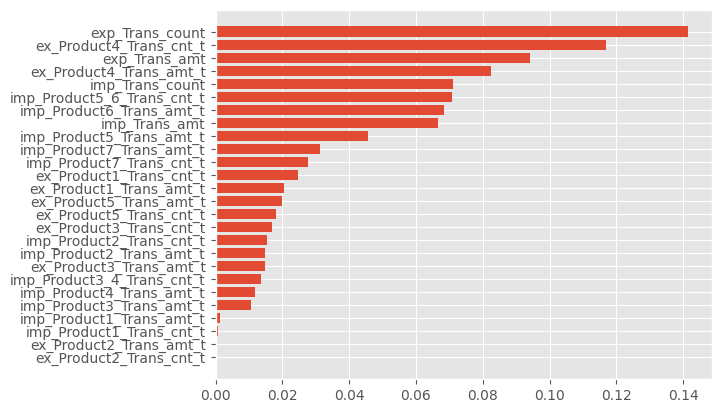

In [15]:
plt.barh(feat_importances.Feature_Name,feat_importances.Feature_Importances)
plt.show()

### 2.2 Train with different methods.

In [17]:
# Use the selected features.
ddt = feat_importances.tail(5)['Feature_Name'].to_list()
trainX, testX, trainY, testY = X_res[ddt], test[ddt], y_new2, test['credit_event']

In [17]:
def met_classi(expected,predicted):
    accuracy = metrics.accuracy_score(expected, predicted)  # accuracy
    Recall = metrics.recall_score(expected, predicted)   # recall
    Prec = metrics.precision_score(expected, predicted)  #precision
    f1 = metrics.f1_score(expected, predicted) # f1 score
    mse=metrics.mean_squared_error(expected, predicted)
    con=metrics.confusion_matrix(expected, predicted)
    print("Accuracy: %.3f%%" % (accuracy * 100.0))
    print("Recall: %.3f%%" % (Recall * 100.0))
    print("Prec: %.3f%%" % (Prec * 100.0))
    print("F1: %.3f%%" % (f1 * 100.0))
    print("MSE: %.3f" % (mse))
    print("ConfusionMatrix:\n" ,con)
    sns.set(font_scale=1)
    hm = sns.heatmap(con,
                    annot=True,fmt='.0f',cmap='RdBu')
    plt.title("ConfusionMatrix", fontsize=15)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    precision, recall, _ = precision_recall_curve(expected, predicted)
    ap = average_precision_score(expected, predicted)
    # Plot PR Curve
    # plt.figure(figsize=(8, 6)) 
    plt.plot(recall, precision,color='darkorange',label='AP={0:0.2f}'.format(ap))
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.05])
    plt.title('Precision-Recall Curve')
    plt.text(0.8,0.2,'AP={0:0.2f}'.format(ap))
    plt.show()
    return

from sklearn.metrics import roc_auc_score, roc_curve
def calculate_auc(y_true, y_score):
    """
    Para:
    - y_true: True label
    - y_score: Predict score
    """
    auc = roc_auc_score(y_true, y_score)
    return auc

from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

def plot_roc_curve(y_true, y_score):
    """
    Para:
    - y_true: True label
    - y_score: Predict score
    """
    # FPR, TPR, thresholds
    fpr, tpr, _ = roc_curve(y_true, y_score)
    # 计算AUC
    auc = roc_auc_score(y_true, y_score)
    
    # Plot ROC Curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()

### Model1. Logistic Regression

In [18]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, accuracy_score, recall_score, precision_score, f1_score, confusion_matrix

model = LogisticRegression()
scoring = {'accuracy': make_scorer(accuracy_score),
           'recall': make_scorer(recall_score),
           'precision': make_scorer(precision_score),
           'f1': make_scorer(f1_score)}

# Grid search
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100]}

# Grid search with 5-fold
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring=scoring, refit='recall')
grid_search.fit(trainX, trainY)

best_model = grid_search.best_estimator_
pre_y = best_model.predict_proba(testX)[:,1]

Best Parameters: {'C': 0.001}
Accuracy: 32.950%
Recall: 90.323%
Prec: 1.283%
F1: 2.531%
MSE: 0.671
ConfusionMatrix:
 [[1032 2154]
 [   3   28]]


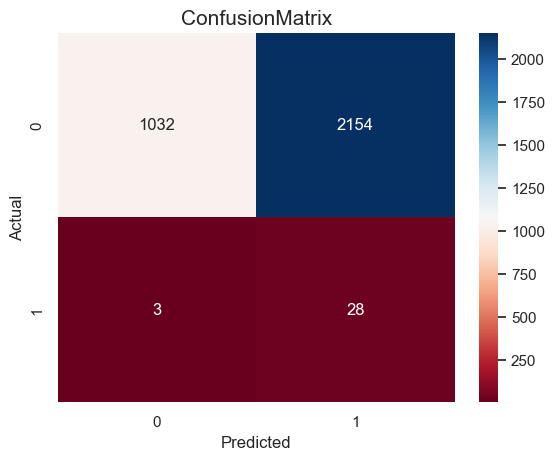

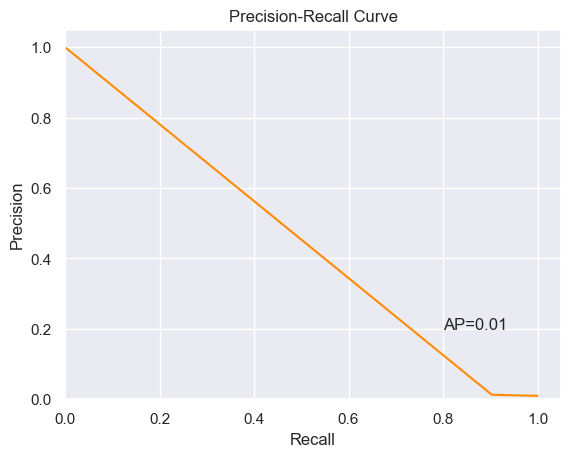

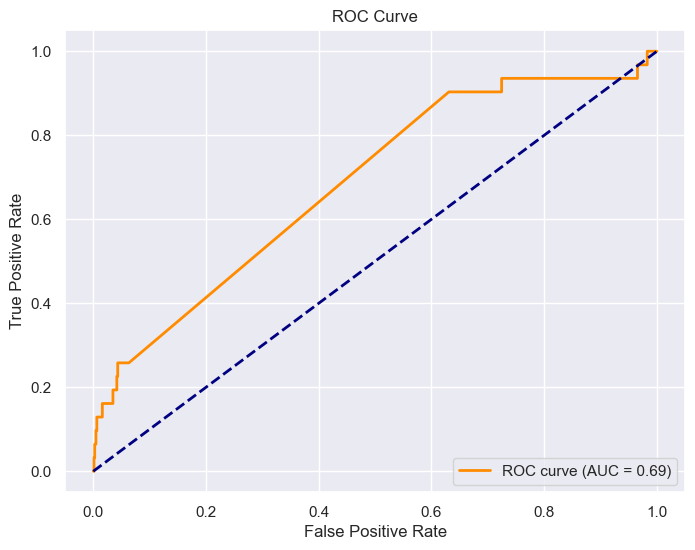

In [19]:
predict_y = best_model.predict(testX)
print("Best Parameters:", grid_search.best_params_)
met_classi(testY,predict_y)
plot_roc_curve(testY,pre_y)

### Model2. SVM

In [124]:
from sklearn.svm import SVC
from sklearn.metrics import make_scorer, accuracy_score, recall_score, precision_score, f1_score, confusion_matrix

model = SVC(random_state=1)
scoring = {'accuracy': make_scorer(accuracy_score),
           'recall': make_scorer(recall_score),
           'f1': make_scorer(f1_score)}

param_grid = {'C': [0.001, 0.01, 0.1],
              'gamma':[0.1,1,10],}

# Grid search with 5-fold
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring=scoring, refit='recall')
grid_search.fit(trainX, trainY)

best_model = grid_search.best_estimator_
pre_y = best_model.predict(testX)

Best Parameters: {'C': 0.1, 'gamma': 0.1}
Accuracy: 23.873%
Recall: 93.548%
Prec: 1.171%
F1: 2.314%
MSE: 0.761
ConfusionMatrix:
 [[ 739 2447]
 [   2   29]]


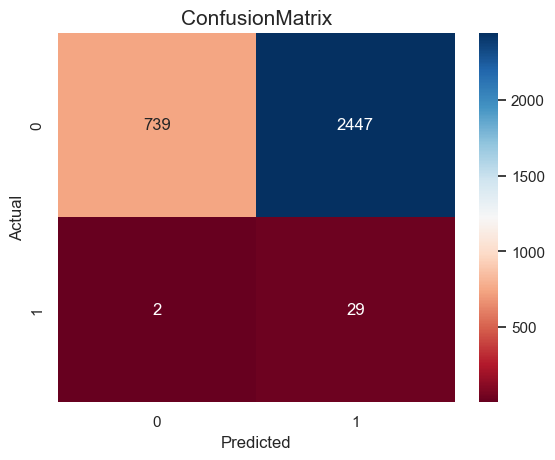

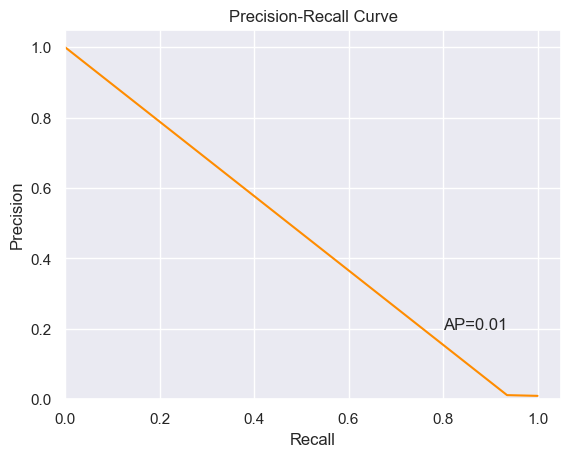

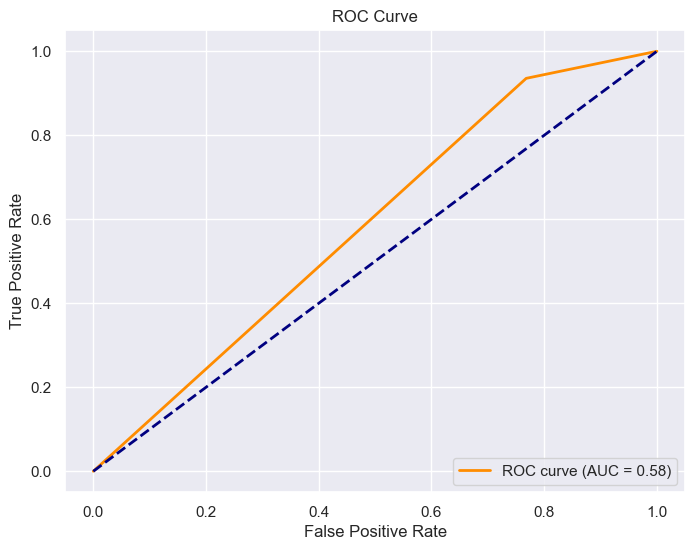

In [125]:
predict_y = np.copy(pre_y)
ymean=np.mean(pre_y)
pre_y[pre_y<ymean]=0
pre_y[pre_y>=ymean]=1
print("Best Parameters:", grid_search.best_params_)
met_classi(testY,pre_y)
plot_roc_curve(testY,predict_y)

### Model3. Decision Tree

In [119]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, accuracy_score, recall_score, precision_score, f1_score, confusion_matrix

model = DecisionTreeClassifier()
scoring = {'accuracy': make_scorer(accuracy_score),
           'recall': make_scorer(recall_score),
           'precision': make_scorer(precision_score),
           'f1': make_scorer(f1_score)}

param_grid = {'max_depth': [10, 20, 30, 40, 50],
              'min_samples_split': [2, 5, 10],
              'min_samples_leaf': [1, 2, 4]}

# Grid search with 5-fold
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring=scoring, refit='recall')
grid_search.fit(trainX, trainY)

best_model = grid_search.best_estimator_
pre_y = best_model.predict(testX)

Best Parameters: {'max_depth': 40, 'min_samples_leaf': 1, 'min_samples_split': 2}
Accuracy: 24.122%
Recall: 93.548%
Prec: 1.175%
F1: 2.321%
MSE: 0.759
ConfusionMatrix:
 [[ 747 2439]
 [   2   29]]


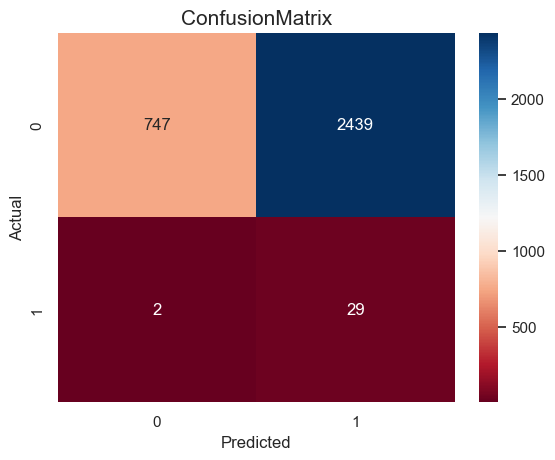

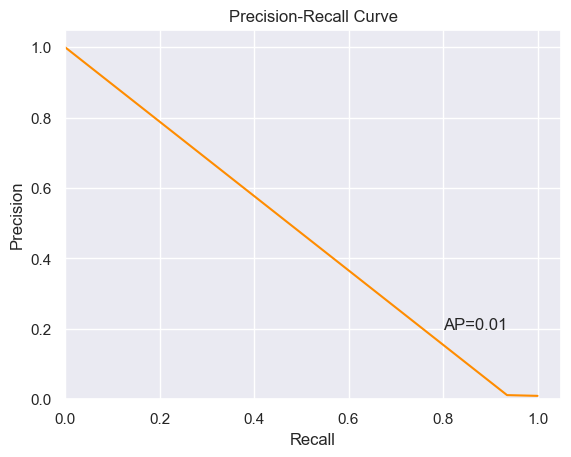

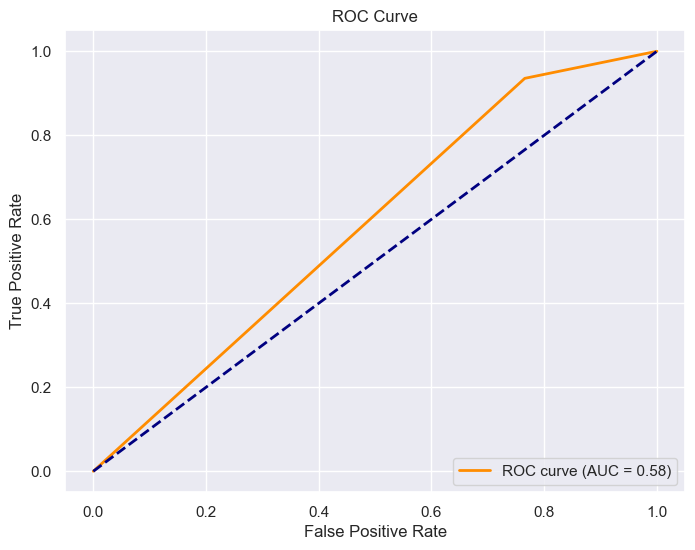

In [120]:
predict_y = best_model.predict(testX)
print("Best Parameters:", grid_search.best_params_)
met_classi(testY,predict_y)
plot_roc_curve(testY,pre_y)

### Model4. Random Forest

In [117]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, accuracy_score, recall_score, precision_score, f1_score, confusion_matrix

model = RandomForestClassifier()
scoring = {'accuracy': make_scorer(accuracy_score),
           'recall': make_scorer(recall_score),
           'precision': make_scorer(precision_score),
           'f1': make_scorer(f1_score)}

param_grid = {'n_estimators': [50, 100, 200],
              'max_depth': [None, 10, 20, 30, 40, 50],
              'min_samples_split': [2, 5, 10],
              'min_samples_leaf': [1, 2, 4]}

# Grid search with 5-fold
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring=scoring, refit='recall')
grid_search.fit(trainX, trainY)

best_model = grid_search.best_estimator_
pre_y = best_model.predict(testX)

Best Parameters: {'max_depth': 40, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Accuracy: 28.287%
Recall: 90.323%
Prec: 1.201%
F1: 2.370%
MSE: 0.717
ConfusionMatrix:
 [[ 882 2304]
 [   3   28]]


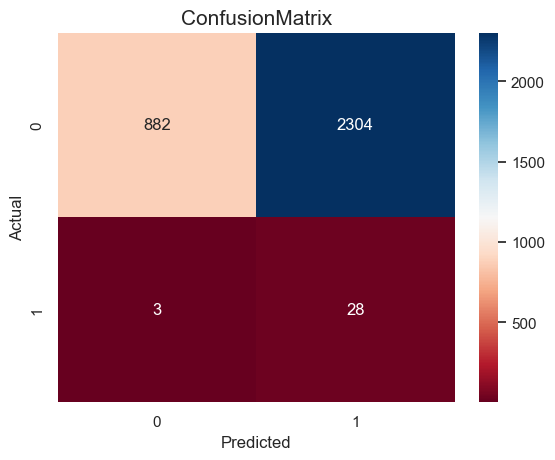

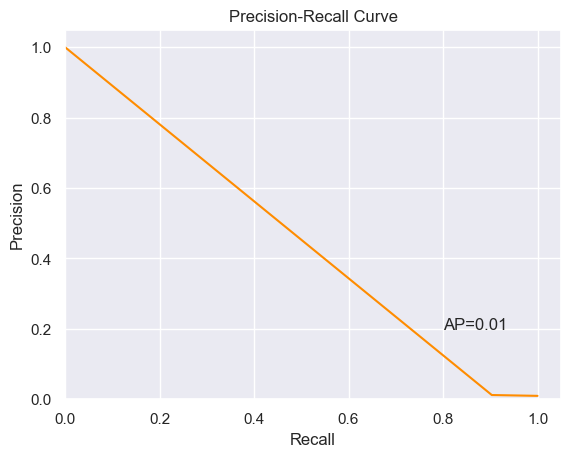

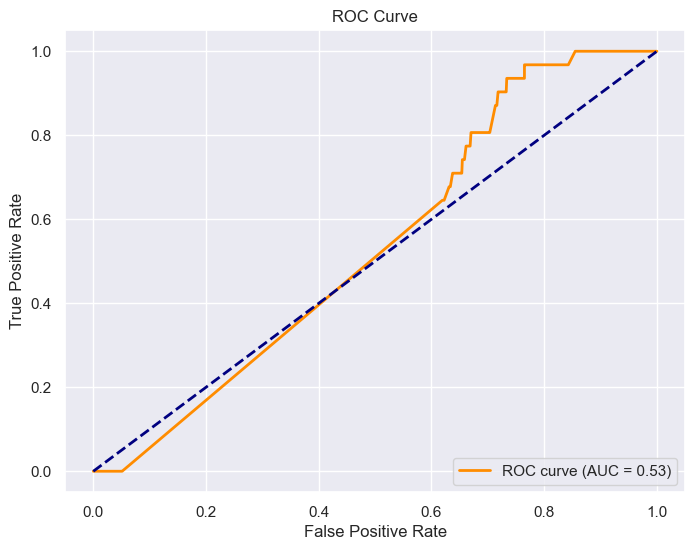

In [118]:
pre_y = best_model.predict_proba(testX)[:,1]
predict_y = best_model.predict(testX)
print("Best Parameters:", grid_search.best_params_)
met_classi(testY,predict_y)
plot_roc_curve(testY,pre_y)

###  Model5. LSTM

- Since panel data is essentially a collection of multiple time series data, the data of each entity can be regarded as a time series, so that the time series model can be applied for analysis and prediction.

In [121]:
model=tf.keras.models.Sequential([
    tf.keras.layers.LSTM(input_dim=1, units=50, return_sequences=True),
    tf.keras.layers.LSTM(input_dim=50, units=100, return_sequences=True),
    tf.keras.layers.LSTM(input_dim=100, units=200, return_sequences=True),
    tf.keras.layers.LSTM(300, return_sequences=False),
    tf.keras.layers.Dense(units=100),
    tf.keras.layers.Dense(units=1)
])
model.add(Activation('sigmoid'))    
start = time.time()
model.summary()
model.compile(optimizer=keras.optimizers.Adam(0.01),loss=keras.losses.mean_squared_error)
model_information=model.fit(trainX, trainY, epochs=10, verbose=1)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 50)          10400     
                                                                 
 lstm_1 (LSTM)               (None, None, 100)         60400     
                                                                 
 lstm_2 (LSTM)               (None, None, 200)         240800    
                                                                 
 lstm_3 (LSTM)               (None, 300)               601200    
                                                                 
 dense (Dense)               (None, 100)               30100     
                                                                 
 dense_1 (Dense)             (None, 1)                 101       
                                                                 
 activation (Activation)     (None, 1)                 0

Epoch 1/10
598/598 [==============================] - 10s 13ms/step - loss: 0.2498
Epoch 2/10
598/598 [==============================] - 8s 13ms/step - loss: 0.2477
Epoch 3/10
598/598 [==============================] - 8s 13ms/step - loss: 0.2512
Epoch 4/10
598/598 [==============================] - 7s 12ms/step - loss: 0.2508
Epoch 5/10
598/598 [==============================] - 7s 12ms/step - loss: 0.2509
Epoch 6/10
598/598 [==============================] - 7s 12ms/step - loss: 0.2509
Epoch 7/10
598/598 [==============================] - 8s 13ms/step - loss: 0.2511
Epoch 8/10
598/598 [==============================] - 8s 13ms/step - loss: 0.2505
Epoch 9/10
598/598 [==============================] - 8s 13ms/step - loss: 0.2505
Epoch 10/10
598/598 [==============================] - 8s 13ms/step - loss: 0.2521


#### Model loss visualization

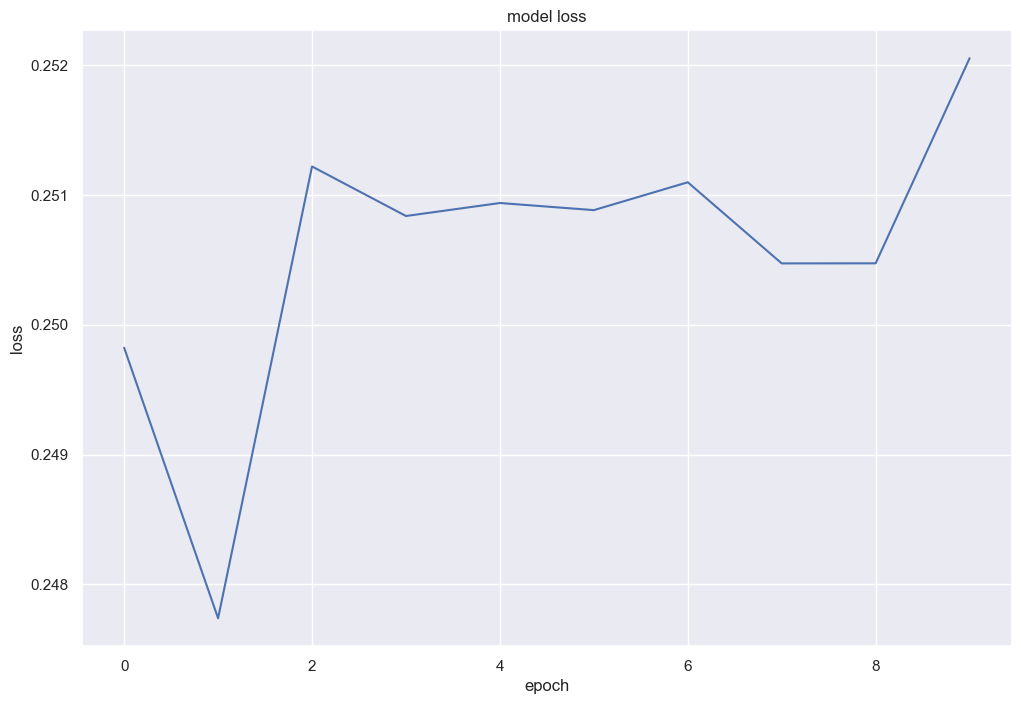

In [122]:
information_loss=model_information.history['loss']
def loss(information_loss):
    plt.figure(figsize=(12, 8))
    plt.plot(information_loss)
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.show()
loss(information_loss)


101/101 [==============================] - 1s 4ms/step
Accuracy: 27.479%
Recall: 93.548%
Prec: 1.229%
F1: 2.426%
MSE: 0.725
ConfusionMatrix:
 [[ 855 2331]
 [   2   29]]


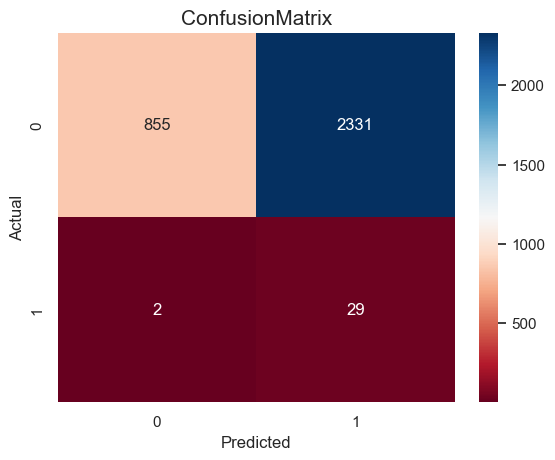

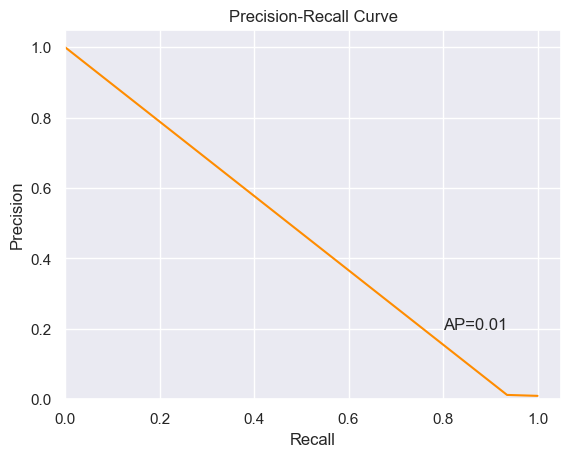

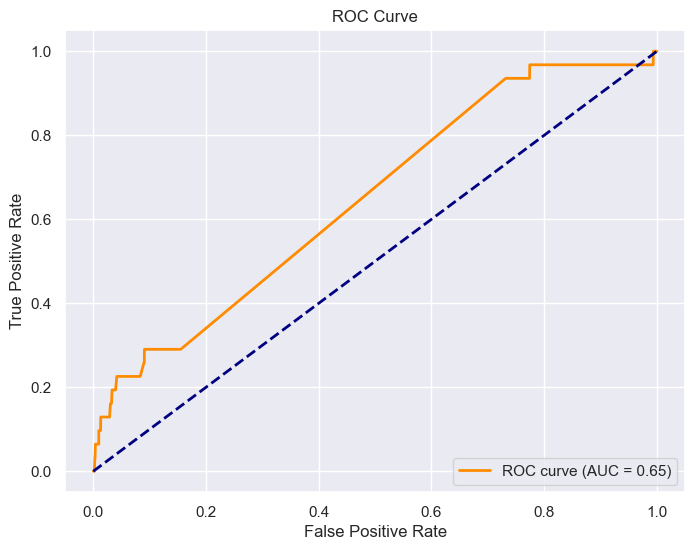

In [123]:
pre_y = model.predict(testX)
predict_y = np.copy(pre_y)
ymean=np.median(pre_y)
pre_y[pre_y<ymean]=0
pre_y[pre_y>=ymean]=1
met_classi(testY,pre_y)
plot_roc_curve(testY,predict_y)

# Future outlook


In this Project, we cleaned and constructed the characteristics of the transaction default data. On this basis, we used five kinds of machine learning models for predictive analysis, and obtained a Recall of more than 90%. We know that this value still needs to be increased, which can be considered from the following aspects:

1. Mining more and more effective factors and features based on fundamentals or timing perspectives, despite the strong limitations and many missing values of transaction data.

2. Increase the data amount of default information, or make more attempts from the perspective of oversampling.

3. Add additional trading information. Transaction data alone may not provide a full extraction of default information, as incidental decisions are mixed in with default decisions.